In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [36]:
import sys
import os
os.getcwd()
sys.path.insert(0, '../src')

In [38]:
from correlation_eval import theils_u

In [2]:
train_data = pd.read_csv('./data/train.csv')

In [3]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


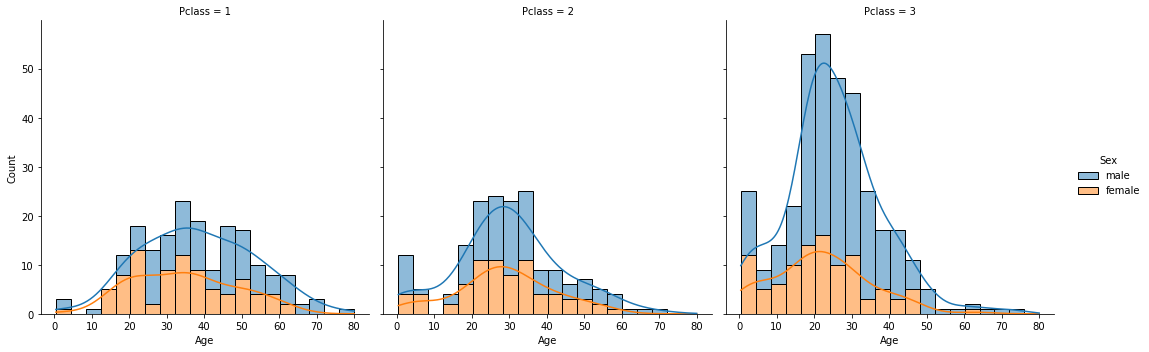

In [9]:
g=sns.displot(data=train_data, x='Age', col='Pclass', hue='Sex', multiple='stack', kde=True, kde_kws={'cut':0})

In [32]:
train_data['Cabin_cat']=train_data['Cabin'].apply(lambda x: 'None' if x is np.nan else x[0])
train_data['Cabin_cat']

0      None
1         C
2      None
3         C
4      None
       ... 
886    None
887       B
888    None
889       C
890    None
Name: Cabin_cat, Length: 891, dtype: object

In [22]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [62]:
for col in ['Cabin_cat', 'Sex', 'Pclass', 'Survived']:
    train_data[col+'_encoded']=LabelEncoder().fit_transform(train_data[col].astype('str'))
train_data['Cabin_cat_encoded']

0      7
1      2
2      7
3      2
4      7
      ..
886    7
887    1
888    7
889    2
890    7
Name: Cabin_cat_encoded, Length: 891, dtype: int32

In [61]:
train_data.loc[:,['Cabin_cat_encoded', 'Sex_encoded', 'Survived_encoded']].corr(method=theils_u)

,Cabin_cat_encoded,Sex_encoded,Survived_encoded
Cabin_cat_encoded,1.000000,0.023626,0.058682
Sex_encoded,0.023626,1.000000,0.232492
Survived_encoded,0.058682,0.232492,1.000000


In [47]:
np.arange(0, 55, 5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [49]:
tips = sns.load_dataset("tips")
tips["total_bill_cut"] = pd.cut(tips["total_bill"],
                                np.arange(0, 55, 5),
                                include_lowest=True,
                                right=False)
tips["total_bill_cut"]

0      [15, 20)
1      [10, 15)
2      [20, 25)
3      [20, 25)
4      [20, 25)
         ...   
239    [25, 30)
240    [25, 30)
241    [20, 25)
242    [15, 20)
243    [15, 20)
Name: total_bill_cut, Length: 244, dtype: category
Categories (10, interval[int64, left]): [[0, 5) < [5, 10) < [10, 15) < [15, 20) ... [30, 35) < [35, 40) < [40, 45) < [45, 50)]